#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr


## LSTM-AE

### Создадим тестовые данные, как в статье (код генерации полностью скопирован)

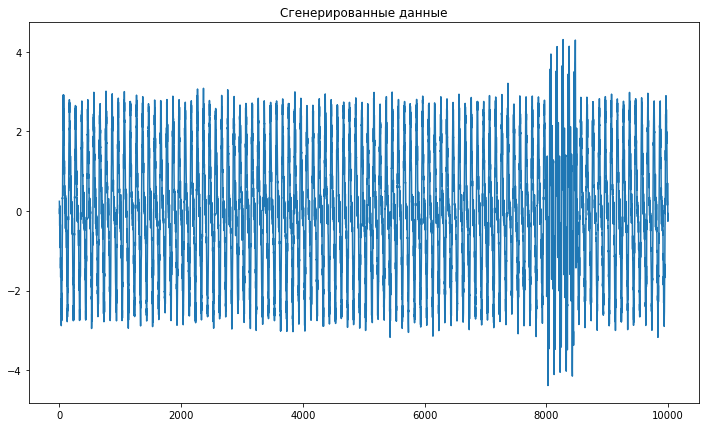

In [90]:
# from random import random
def gen_wave():
    t = np.arange(0.0, 100.0, 0.01)
    wave1 = np.sin(2 * 2 * np.pi * t)
    noise = np.random.normal(0, 0.2, len(t))
    wave1 = wave1 + noise
    wave2 = np.sin(2 * np.pi * t)
    t_rider = np.arange(0.0, 5.0, 0.01)
    wave3 = -2*np.sin(10 * np.pi * t_rider)
    insert = round(0.8 * len(t))
    wave1[insert:insert + 500] = wave1[insert:insert + 500] + wave3
    return wave1 - 2*wave2

wave = gen_wave()

plt.figure(figsize=(12,7))
plt.plot(wave)
plt.title('Сгенерированные данные')

def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

def get_split_prep_data(train_start, train_end,
                          test_start, test_end, sequence_length):
    data = gen_wave()

    # train data

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)


    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    return X_train, y_train, X_test, y_test

X_train,y_train, X_test, y_test = get_split_prep_data(0, 6999, 7000, 10000, 13)

### Модель LSTM AE

In [91]:
num_cells=64
dropout_rate=0.1
lr=0.01

timesteps =  X_train.shape[1] # 1
n_features =  X_train.shape[2] # лаг предыдущих значений


In [92]:
%%time
import keras
lstm_autoencoder = Sequential()

# Encoder
lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

adam = Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 256)            275456    
                                                                 
 lstm_13 (LSTM)              (None, 64)                82176     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 64)            0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_15 (LSTM)              (None, 1, 256)            328704    
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 12)            3084      
 tributed)                                            

In [93]:

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=20, 
                                                batch_size=200, 
                                                validation_split=0.2,
                                                verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
                                                

Epoch 1/20
28/28 - 6s - loss: 0.9178 - val_loss: 0.7651 - 6s/epoch - 204ms/step
Epoch 2/20
28/28 - 1s - loss: 0.2306 - val_loss: 0.0904 - 621ms/epoch - 22ms/step
Epoch 3/20
28/28 - 1s - loss: 0.0866 - val_loss: 0.0871 - 618ms/epoch - 22ms/step
Epoch 4/20
28/28 - 1s - loss: 0.0843 - val_loss: 0.0866 - 718ms/epoch - 26ms/step
Epoch 5/20
28/28 - 1s - loss: 0.0840 - val_loss: 0.0866 - 702ms/epoch - 25ms/step
Epoch 6/20
28/28 - 1s - loss: 0.0840 - val_loss: 0.0863 - 753ms/epoch - 27ms/step
Epoch 7/20
28/28 - 1s - loss: 0.0838 - val_loss: 0.0854 - 674ms/epoch - 24ms/step
Epoch 8/20
28/28 - 1s - loss: 0.0773 - val_loss: 0.0521 - 661ms/epoch - 24ms/step
Epoch 9/20
28/28 - 1s - loss: 0.0374 - val_loss: 0.0203 - 643ms/epoch - 23ms/step
Epoch 10/20
28/28 - 1s - loss: 0.0167 - val_loss: 0.0149 - 652ms/epoch - 23ms/step
Epoch 11/20
28/28 - 1s - loss: 0.0139 - val_loss: 0.0139 - 676ms/epoch - 24ms/step
Epoch 12/20
28/28 - 1s - loss: 0.0135 - val_loss: 0.0138 - 687ms/epoch - 25ms/step
Epoch 13/20
28/

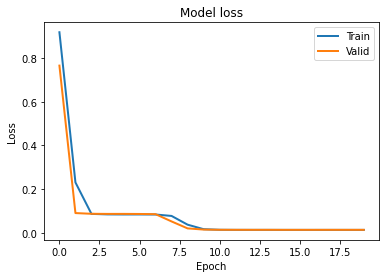

In [94]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Предсказывание значений, рассчет MSE 

In [95]:
predicted_train = lstm_autoencoder.predict(X_train)
predicted_test = lstm_autoencoder.predict(X_test)

X_train_plt = np.reshape(X_train, (X_train.shape[0], X_train.shape[2], 1))
predict_train_plt = np.reshape(predicted_train, (predicted_train.shape[0], predicted_train.shape[2], 1))

X_test_plt = np.reshape(X_test, (X_test.shape[0], X_test.shape[2], 1))
predict_test_plt = np.reshape(predicted_test, (predicted_test.shape[0], predicted_test.shape[2], 1))


In [96]:
mse = np.mean(np.power(X_test_plt- predict_test_plt, 2), axis=1)
mse_train = np.mean(np.power(X_train_plt- predict_train_plt, 2), axis=1)

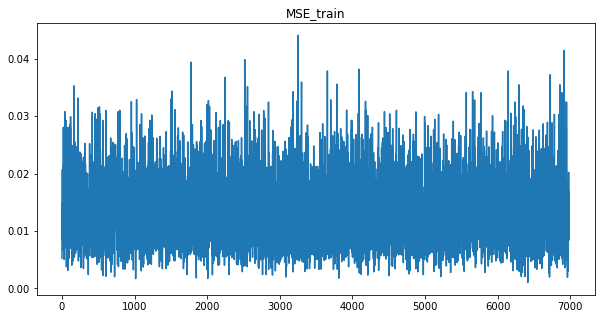

In [97]:
plt.figure(figsize=(10,5))
plt.title("MSE_train")
plt.plot(mse_train)

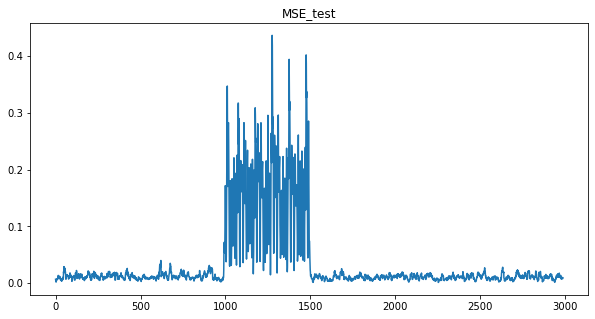

In [98]:
plt.figure(figsize=(10,5))
plt.title("MSE_test")
plt.plot(mse)

#### Большие значения MSE в аномальной зоне

### OCSVM

In [99]:
e=X_train - predicted_train
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples,nx*ny))

In [103]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.0055, kernel="rbf", gamma=1.5)
clf.fit(d2_e)

e_t=X_test - predicted_test
nsamples, nx, ny = e_t.shape
d2_e_t = e_t.reshape((nsamples,nx*ny))
y_scores = clf.predict(d2_e_t)

In [128]:
arr = []
for i in range(len(y_scores)):
    if y_scores[i]==-1:
        arr.append(y_test[i])
    else: arr.append(None)

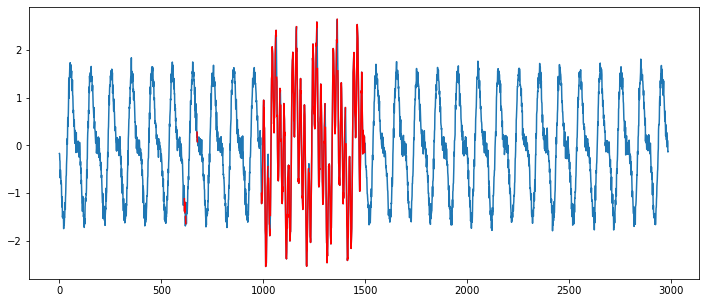

In [130]:
plt.figure(figsize=(12,5))
plt.plot(y_test)
plt.plot(arr, color='r')
